In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.enable_eager_execution()

/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import src.gan as gan

# want to visualise the prior learned by a gan/rim/vae/...

In [14]:
# generate a simple manifold of data
N = 20000


def spiral():
    t = np.linspace(0, 10, N)
    t = tf.constant(t, dtype=tf.float32)
    freq = 2
    return t*tf.sin(t*freq), t*tf.cos(t*freq)

def gaussian_grid():
    steps = 3
    stddev = 10/(3*5)
    X, Y = np.meshgrid(np.linspace(0, 10, steps), np.linspace(0, 10, steps))
    centers = np.stack([X.ravel(), Y.ravel()], axis=1)
    x = np.vstack([c+np.random.standard_normal((N//(steps**2), 2))*stddev for c in centers])
    return tf.constant(x, dtype=tf.float32)

def get_batch(data, batch_size):
    batch = tf.gather(data, np.random.randint(0, data.shape[0], batch_size))
    return batch + tf.random_normal(shape=batch.shape, stddev=0.1)

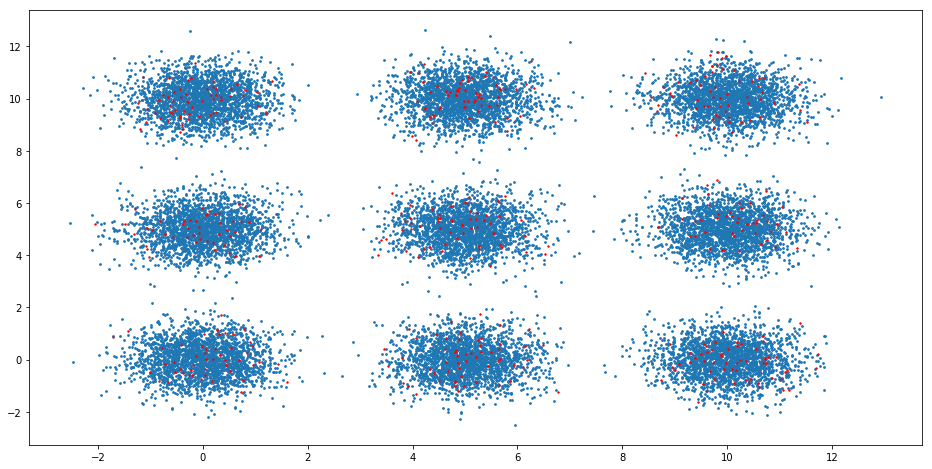

In [15]:
data = gaussian_grid()
plt.figure(figsize=(16, 8))
plt.scatter(data[:, 0], data[:, 1], s=3)
batch = get_batch(data, 500)
plt.scatter(batch[:, 0], batch[:, 1], c='r', s=2)

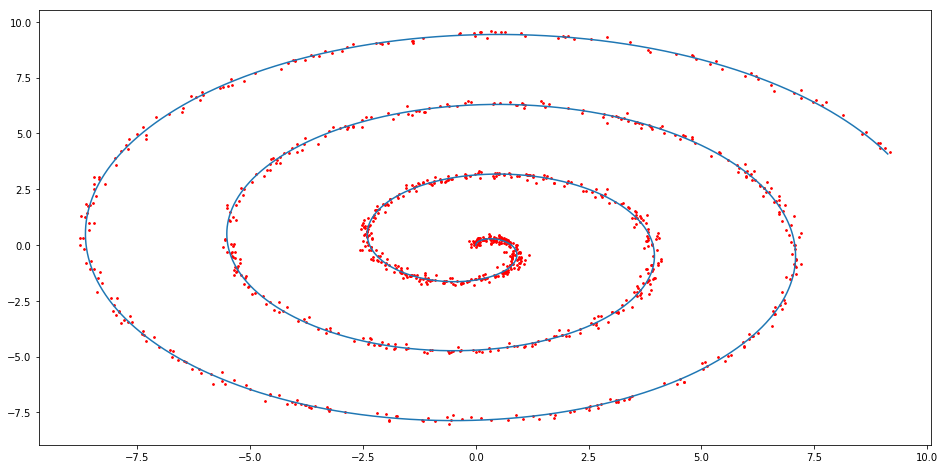

In [5]:
data = tf.stack(spiral(), axis=1) # truth

plt.figure(figsize=(16, 8))
plt.plot(data[:, 0], data[:, 1])

batch = get_batch(data, 1000)
plt.scatter(batch[:, 0], batch[:, 1], c='r', s=3)

In [16]:
def calc_discrim_loss(p_real, p_fake):
    discrim_loss = tf.losses.sigmoid_cross_entropy(
        logits=p_real,
        multi_class_labels=tf.ones_like(p_real))
    discrim_loss += tf.losses.sigmoid_cross_entropy(
        logits=p_fake,
        multi_class_labels=tf.zeros_like(p_fake))
    return discrim_loss

In [17]:
def calc_grads(switch):
    with tf.GradientTape() as tape:
        x = get_batch(data, batch_size)
        z = tf.random_normal([batch_size, 1])

        fake = generator(z)
        
        p_real = discriminator(x)
        p_fake = discriminator(fake)

        discrim_loss = calc_discrim_loss(p_real, p_fake)

        # generator is trying to fool the discriminator
        gen_loss = tf.losses.sigmoid_cross_entropy(
            logits=p_fake,
            multi_class_labels=tf.ones_like(p_fake))
        
    if switch:
        return list(zip(tape.gradient(discrim_loss, discriminator.variables), discriminator.variables))
    else:
        return list(zip(tape.gradient(gen_loss, generator.variables), generator.variables))           

In [18]:
n = 30
margin = 5
x_ = np.linspace(0-margin, 10+margin, n)
y_ = np.linspace(0-margin, 10+margin, n)
X, Y = np.meshgrid(x_, y_)
Z = tf.constant(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=tf.float32)

In [21]:
width = 64
depth = 4

batch_size = 1000

def gen_dense_layers(width, depth):
    return [tf.keras.layers.Dense(width, activation=tf.nn.selu) 
           for _ in range(depth)]

discriminator = tf.keras.Sequential(gen_dense_layers(width, depth) +
                                     [tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
generator =  tf.keras.Sequential(gen_dense_layers(width, depth) +
                                  [tf.keras.layers.Dense(2)])

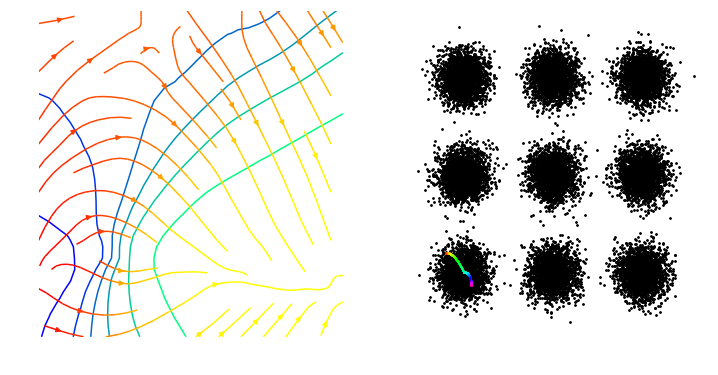

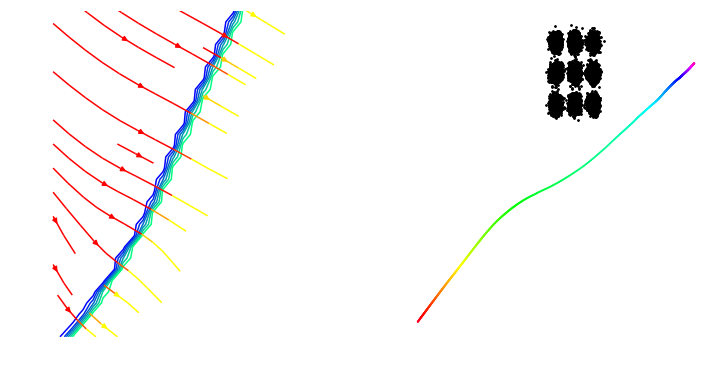

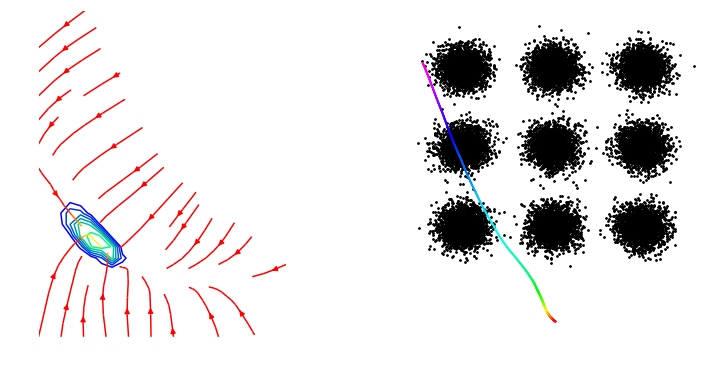

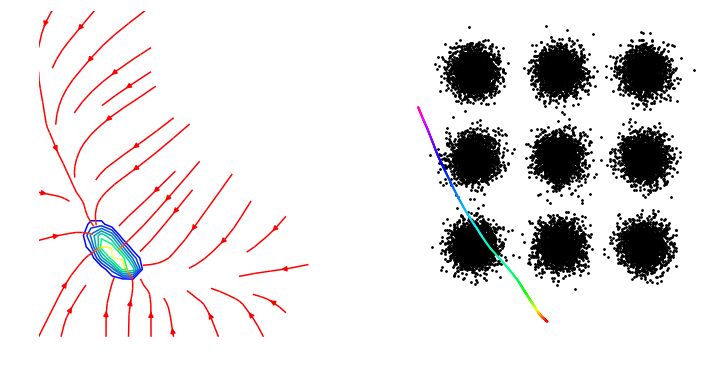

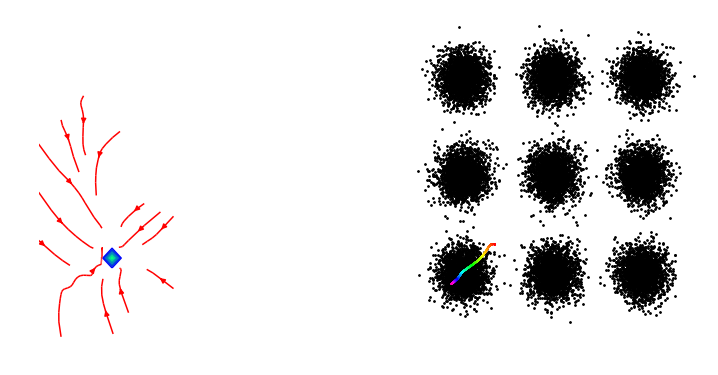

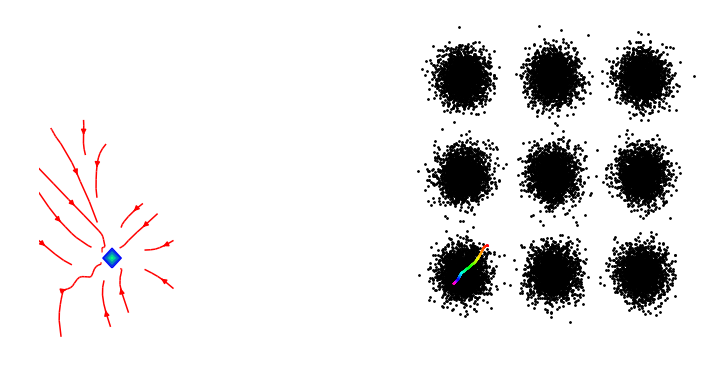

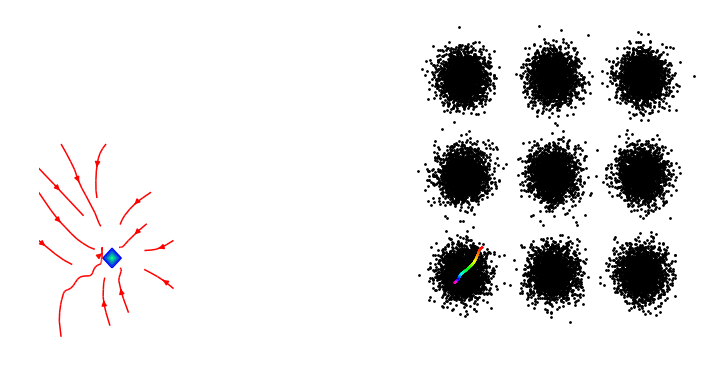

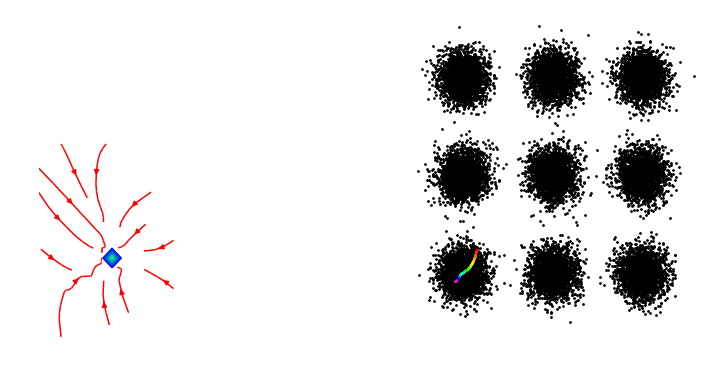

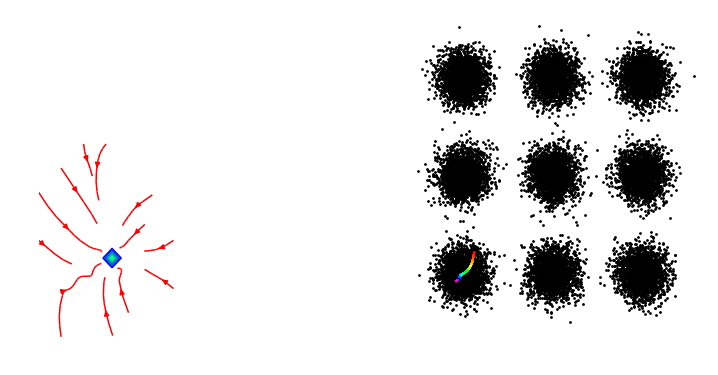

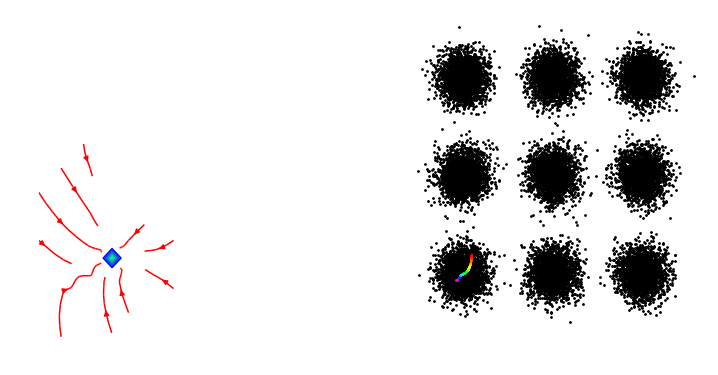

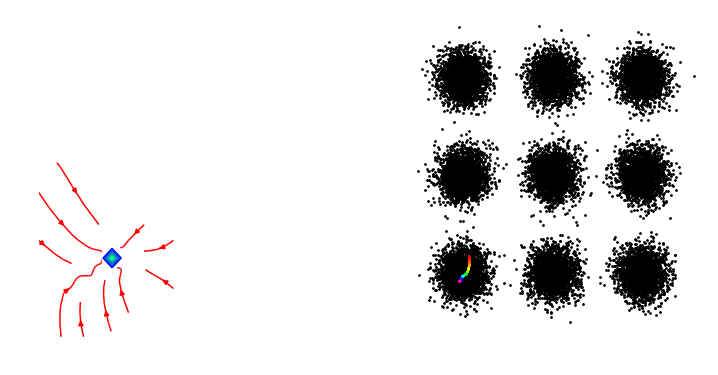

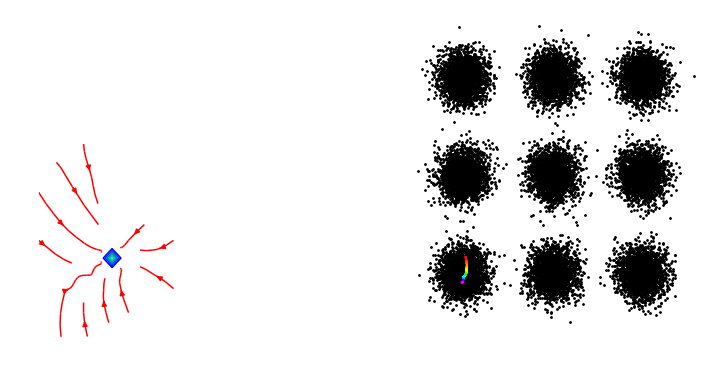

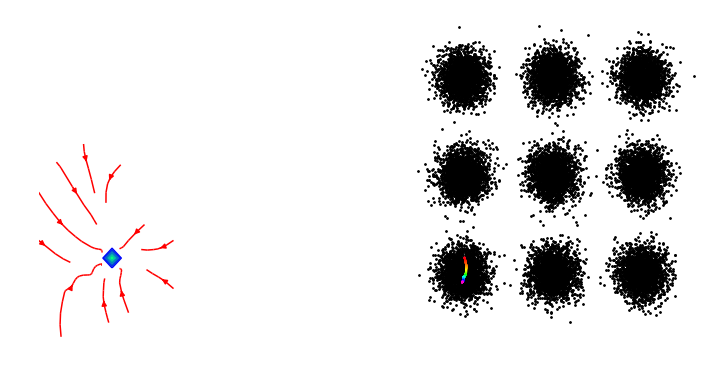

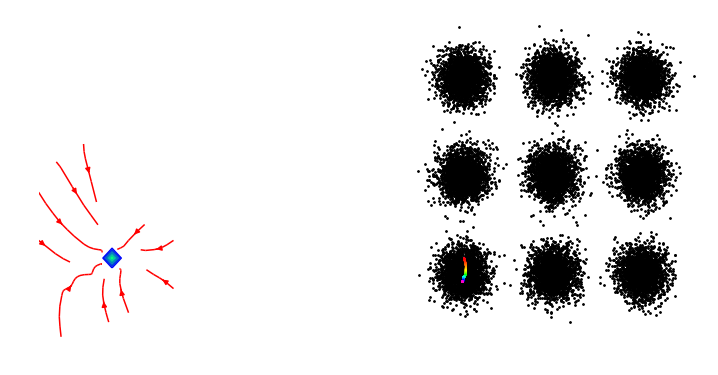

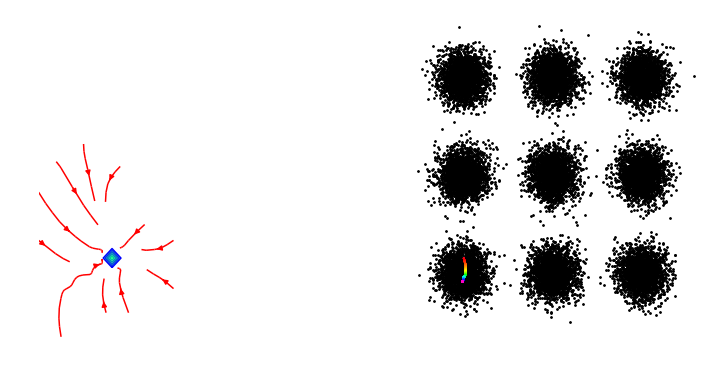

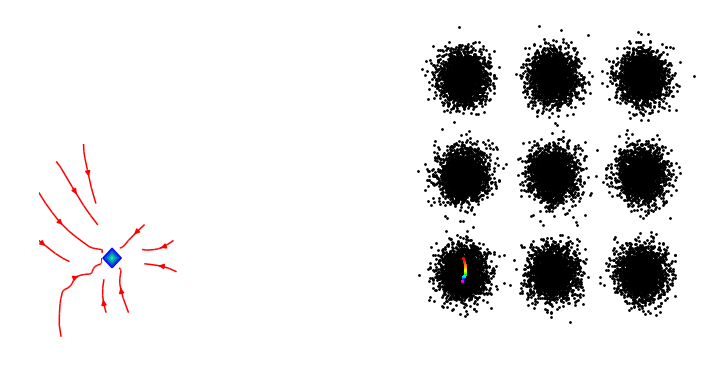

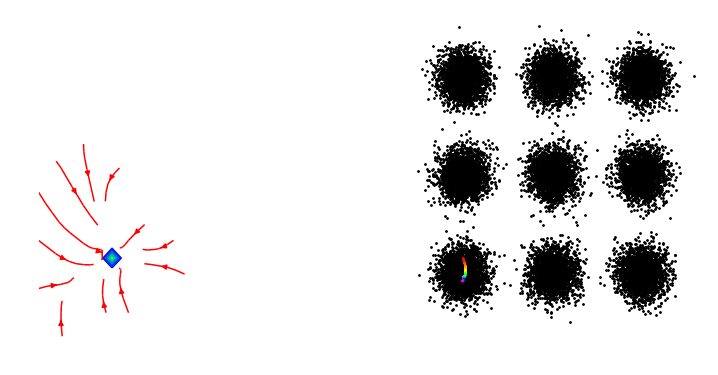

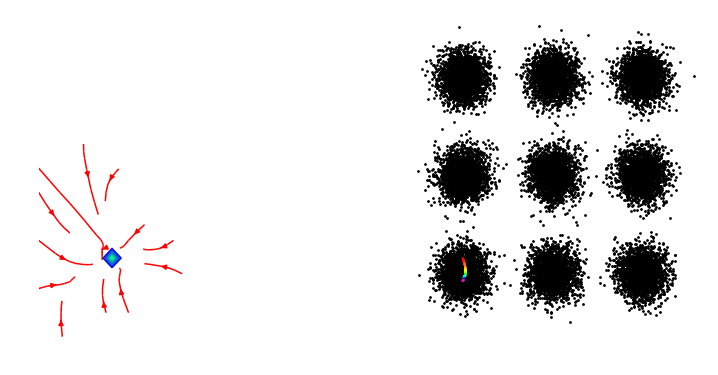

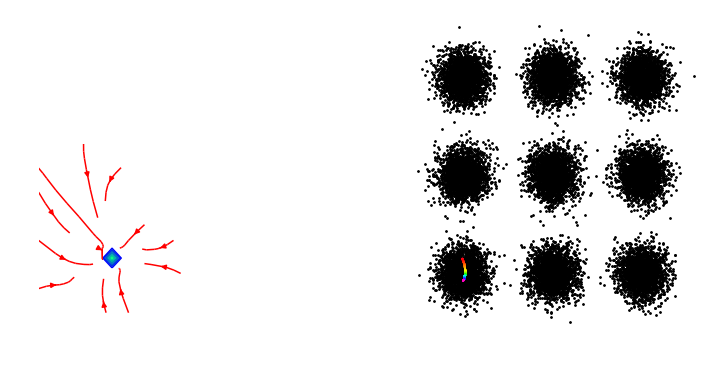

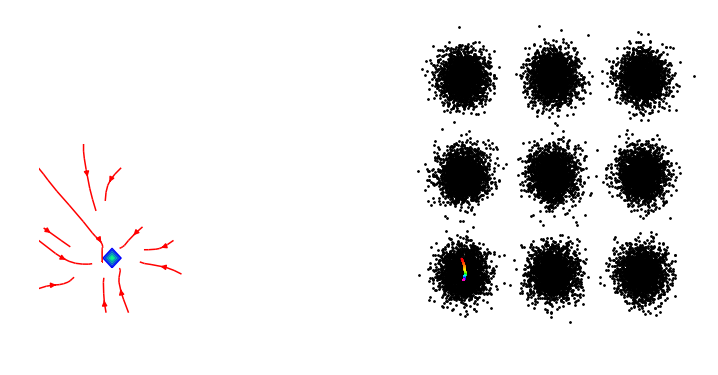

In [22]:
opt = tf.train.AdamOptimizer()
count = 0
for i in range(2000):
    opt.apply_gradients(calc_grads(True))
    opt.apply_gradients(calc_grads(False))
    
    if i % 100 == 0:
        plt.figure(figsize=(12,6))

        with tf.GradientTape() as tape:
            tape.watch(Z)
            p_fake = discriminator(Z)
        dp = tape.gradient(p_fake, Z)
        
        plt.subplot(1,2,1)
        plt.axis('off')
        plt.contour(X, Y, np.reshape(p_fake, [n, n]), cmap=plt.cm.winter)
        plt.streamplot(X, Y, np.reshape(dp[:, 0], [n, n]), 
                       np.reshape(dp[:, 1], [n, n]), 
                       density=0.5, cmap=plt.cm.autumn,
                       color=np.reshape(p_fake, [n, n]))

        
        plt.subplot(1,2,2)
        plt.axis('off')
        plt.scatter(data[:, 0], data[:, 1], c='k', s=3)

        
        # generators density fn.
        # where does it map a line? color gives density
        z = tf.constant(np.linspace(-3, 3, n*n), dtype=tf.float32, shape=[n*n, 1])
        fake = generator(z)
        
        plt.scatter(fake[:, 0],fake[:, 1],  cmap=plt.cm.gist_rainbow,
                    c=range(1, n*n+1), s=1)

In [ ]:
# gans are a bad idea bc?

# mode collapse!! need to be able to verify that they havent dropped any modes.
# otherwise they might push solutions away from places with high true likelihood.

In [52]:
# irrelevant for now...

class Forward():
    """
    The forward process
    """
    def __init__(self):
        Q, R = np.linalg.qr(np.random.standard_normal((2,2)))
        self.A = tf.constant(Q, dtype=tf.float32)
        self.stddev = 1.0
    
    def __call__(self, x):
        y = tf.transpose(tf.matmul(self.A, x, transpose_b=True))
        y = y[:, 0:1]  # subsample.
        return y + tf.random_normal(y.shape, stddev=self.stddev)
    
f = Forward()
y = f(data)  # observations

In [ ]:
# plt.subplot(1,2,2)
# o = y.numpy()
# idx = np.random.choice(range(len(o)), len(o), replace=False)
# plt.scatter(range(len(o)), o[idx], c=plt.cm.autumn(idx))